
Training on snapshot 1/10: file_data_00_00_00.csv
[Epoch 001] Loss: 22.5420 | GW-Coverage: 0.00% | Cell-Coverage: 0.00%
[Epoch 002] Loss: 22.3335 | GW-Coverage: 11.11% | Cell-Coverage: 0.00%
[Epoch 003] Loss: 21.9160 | GW-Coverage: 12.96% | Cell-Coverage: 0.00%
[Epoch 004] Loss: 21.3090 | GW-Coverage: 14.81% | Cell-Coverage: 0.00%
[Epoch 005] Loss: 21.2814 | GW-Coverage: 16.67% | Cell-Coverage: 0.00%
[Epoch 006] Loss: 21.0815 | GW-Coverage: 25.93% | Cell-Coverage: 0.00%
[Epoch 007] Loss: 20.3628 | GW-Coverage: 25.93% | Cell-Coverage: 0.00%
[Epoch 008] Loss: 19.7969 | GW-Coverage: 25.93% | Cell-Coverage: 0.00%
[Epoch 009] Loss: 19.2469 | GW-Coverage: 20.37% | Cell-Coverage: 0.00%
[Epoch 010] Loss: 18.2530 | GW-Coverage: 40.74% | Cell-Coverage: 0.00%
[Epoch 011] Loss: 17.8877 | GW-Coverage: 33.33% | Cell-Coverage: 0.00%
[Epoch 012] Loss: 17.5257 | GW-Coverage: 37.04% | Cell-Coverage: 0.02%
[Epoch 013] Loss: 16.9333 | GW-Coverage: 37.04% | Cell-Coverage: 0.07%
[Epoch 014] Loss: 16.3630 |

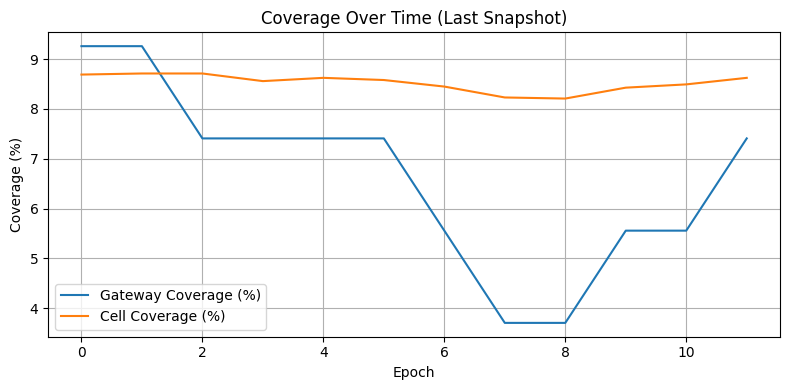

Final trained model saved as: final_model.pt


In [ ]:
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from src.train_model import train_until_converged

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Loss weights ===
loss_weights = {
    'alpha': 10.0,
    'beta': 1.0,
    'gamma': 0.3,
    'delta': 100.0,
    'zeta': 0.5,
    'spatial': 0.0
}


# === Select snapshot files ===
all_files = sorted(os.listdir(folder_path))
snapshot_files = all_files[::10][:10]

model = None
optimizer = None

for idx, file in enumerate(snapshot_files):
    print(f"\nTraining on snapshot {idx + 1}/{len(snapshot_files)}: {file}")

    # === Load and prepare graph ===
    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data = build_hetero_graph(satellites, gateways, cells)

    for node_type in ['sat', 'gateway', 'cell']:
        data[node_type].x = normalize(data[node_type].x)
    data = data.to(device)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # === Visibility matrices ===
    visibility_matrix = torch.zeros((num_sats, num_gws), device=device)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        visibility_matrix[src, dst] = 1

    cell_visibility_matrix = torch.zeros((num_sats, num_cells), device=device)
    print("\n=== Visibility Diagnostics ===")
    print(f"Total Satellites: {num_sats}")
    print(f"Total Gateways: {num_gws}")
    print(f"Total Cells: {num_cells}")
    print(f"Visible Sat→GW links: {visibility_matrix.nonzero().size(0)}")
    print(f"Visible Sat→Cell links: {cell_visibility_matrix.nonzero().size(0)}")

    sat_to_gw = data['sat', 'connects', 'gateway'].edge_index
    gw_to_cell = data['gateway', 'serves', 'cell'].edge_index
    for gw_idx, cell_idx in gw_to_cell.t():
        sats_connected = (sat_to_gw[1] == gw_idx).nonzero(as_tuple=True)[0]
        for s_idx in sats_connected:
            sat_id = sat_to_gw[0, s_idx]
            cell_visibility_matrix[sat_id, cell_idx] = 1

    cell_demands = data['cell'].x[:, -1].unsqueeze(1)
    cell_coordinates = data['cell'].x[:, :2]

    aux_inputs = {
        'visibility_matrix': visibility_matrix,
        'cell_visibility_matrix': cell_visibility_matrix,
        'cell_demands': cell_demands,
        'cell_coordinates': cell_coordinates
    }

    # === Model init (once) ===
    if model is None:
        model = SatGatewayGNN(
            hidden_dim=64,
            num_gateways=num_gws,
            num_cells=num_cells
        ).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        assert model.num_gateways == num_gws and model.num_cells == num_cells, \
            f"Mismatch in gateway/cell count between snapshots. Model was built with {model.num_gateways}/{model.num_cells}, current snapshot has {num_gws}/{num_cells}."

    # === Train ===
    model, history = train_until_converged(
        model=model,
        data=data,
        optimizer=optimizer,
        aux_inputs=aux_inputs,
        loss_weights=loss_weights,
        epochs=100,
        patience=10,
        verbose=True
    )

    # === Save training history and model ===
    history_df = pd.DataFrame(history)
    history_file = f"training_history_snapshot_{idx+1:02d}.csv"
    model_file = f"trained_model_snapshot_{idx+1:02d}.pt"

    history_df.to_csv(history_file, index=False)
    torch.save(model.state_dict(), model_file)

    print(f"Saved training history to: {history_file}")
    print(f"Saved model to: {model_file}")

# === Final coverage plot for last snapshot ===
plt.figure(figsize=(8, 4))
plt.plot([x * 100 for x in history['gateway_coverage']], label='Gateway Coverage (%)')
plt.plot([x * 100 for x in history['cell_coverage']], label='Cell Coverage (%)')
plt.xlabel('Epoch')
plt.ylabel('Coverage (%)')
plt.title('Coverage Over Time (Last Snapshot)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Save final trained model separately ===
final_model_path = "final_model.pt"
torch.save(model.state_dict(), final_model_path)
print(f"Final trained model saved as: {final_model_path}")


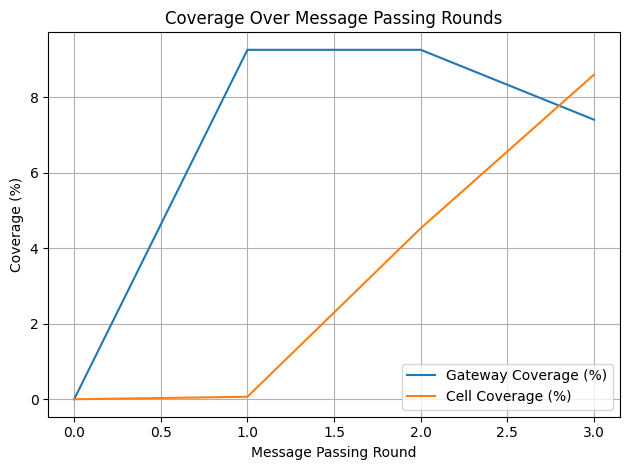

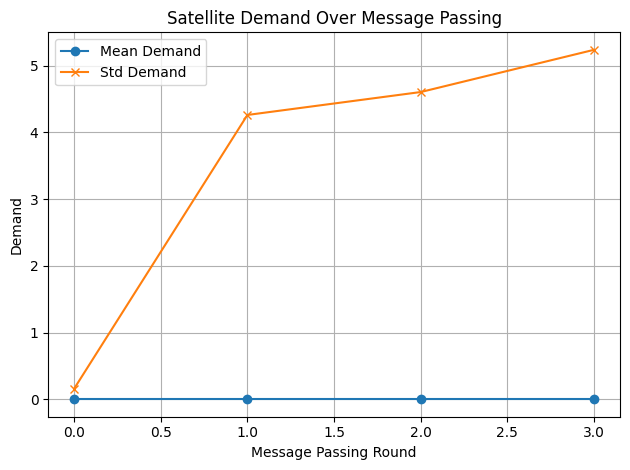

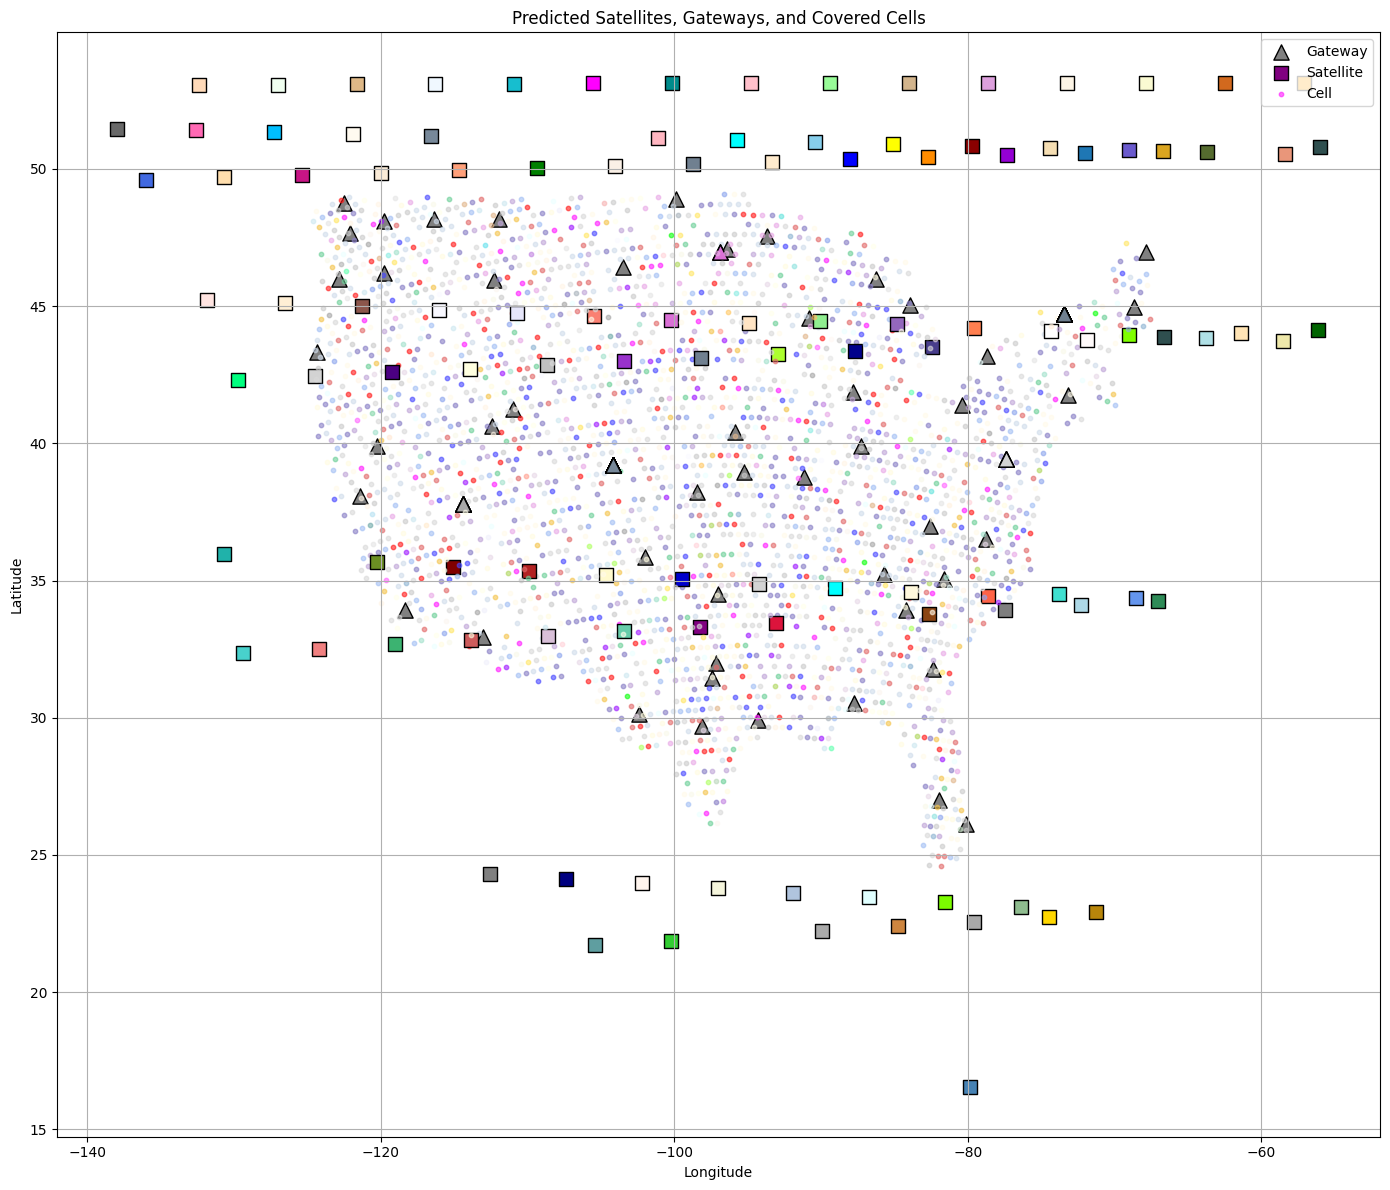

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from ast import literal_eval

# === CONFIG ===
# === CONFIG ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
cells_with_gw_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
model_path = "final_model.pt"
hidden_dim = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Select 11th file in folder ===
all_files = sorted(os.listdir(folder_path))
snapshot_file = all_files[10]  # Adjust index for 10th or 11th file
snapshot_id = snapshot_file.split(".")[0]

hidden_dim = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === NORMALIZATION ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === COVERAGE METRICS ===
def compute_coverage(gw_probs, cell_probs, vis_matrix, cell_vis_matrix):
    gw_cov = (torch.sum(gw_probs * vis_matrix, dim=0) >= 1).sum().item() / vis_matrix.shape[1]
    cell_cov = (torch.sum(cell_probs * cell_vis_matrix, dim=0) >= 1).sum().item() / cell_vis_matrix.shape[1]
    return gw_cov, cell_cov

# === LIGHTEN COLOR ===
def lighten_color(color, amount=0.5):
    import colorsys
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

# === LOAD STATIC DATA ===
gw_df = pd.read_csv(gateway_file)
cells_df = pd.read_csv(cells_with_gw_file, index_col="cell_id")

# === LOAD SNAPSHOT ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=snapshot_file)
sat_df = pd.DataFrame(satellites)
raw_sat_positions = sat_df[['longitude', 'latitude']].values

data = build_hetero_graph(satellites, gateways, cells)
for node_type in ['sat', 'gateway', 'cell']:
    data[node_type].x = normalize(data[node_type].x)
data = data.to(device)

num_sats = data['sat'].num_nodes
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes

# === Build visibility matrices ===
visibility_matrix = torch.zeros((num_sats, num_gws), device=device)
for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
    visibility_matrix[src, dst] = 1

cell_visibility_matrix = torch.zeros((num_sats, num_cells), device=device)
sat_to_gw = data['sat', 'connects', 'gateway'].edge_index
gw_to_cell = data['gateway', 'serves', 'cell'].edge_index
for gw_idx, cell_idx in gw_to_cell.t():
    sats_connected = (sat_to_gw[1] == gw_idx).nonzero(as_tuple=True)[0]
    for s_idx in sats_connected:
        sat_id = sat_to_gw[0, s_idx]
        cell_visibility_matrix[sat_id, cell_idx] = 1

cell_demands = data['cell'].x[:, -1].unsqueeze(1).to(device)

# === LOAD FINAL MODEL ===
model = SatGatewayGNN(hidden_dim=hidden_dim, num_gateways=num_gws, num_cells=num_cells).to(device)
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))

model.eval()

# === RUN FORWARD PASS ===
coverage_stats = []
demand_stats = []

with torch.no_grad():
    gw_logits_all, cell_logits_all, _ = model(
        data=data,
        cell_visibility_matrix=cell_visibility_matrix,
        cell_demands=cell_demands
    )

    for i in range(len(gw_logits_all)):
        gw_probs = torch.softmax(gw_logits_all[i], dim=1)
        cell_logits = cell_logits_all[i]
        masked_logits = cell_logits.clone()
        masked_logits[~cell_visibility_matrix.bool()] = -1e9
        cell_probs = torch.softmax(masked_logits.transpose(0, 1), dim=1).transpose(0, 1)  # mutual exclusive    


        demand = torch.matmul(cell_probs, cell_demands).squeeze()
        gw_cov, cell_cov = compute_coverage(gw_probs, cell_probs, visibility_matrix, cell_visibility_matrix)
        coverage_stats.append((gw_cov, cell_cov))
        demand_stats.append((demand.mean().item(), demand.std().item()))

# === PLOT COVERAGE OVER ROUNDS ===
rounds = list(range(len(coverage_stats)))
gw_covs = [x[0] * 100 for x in coverage_stats]
cell_covs = [x[1] * 100 for x in coverage_stats]

plt.figure()
plt.plot(rounds, gw_covs, label='Gateway Coverage (%)')
plt.plot(rounds, cell_covs, label='Cell Coverage (%)')
plt.xlabel("Message Passing Round")
plt.ylabel("Coverage (%)")
plt.title("Coverage Over Message Passing Rounds")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("coverage_over_rounds.png")
plt.show()

# === PLOT DEMAND OVER ROUNDS ===
means = [x[0] for x in demand_stats]
stds = [x[1] for x in demand_stats]

plt.figure()
plt.plot(rounds, means, marker='o', label='Mean Demand')
plt.plot(rounds, stds, marker='x', label='Std Demand')
plt.xlabel("Message Passing Round")
plt.ylabel("Demand")
plt.title("Satellite Demand Over Message Passing")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("demand_over_rounds.png")
plt.show()

# === FINAL ASSIGNMENTS AND MAP ===
final_gw_probs = torch.softmax(gw_logits_all[-1], dim=1).cpu()
final_cell_logits = cell_logits_all[-1].cpu()
final_cell_probs = torch.softmax(final_cell_logits.transpose(0, 1), dim=1).transpose(0, 1)  # mutual exclusive
pred_gateways = final_gw_probs.argmax(dim=1).numpy()
pred_cells = final_cell_probs.argmax(dim=0).numpy()  # [num_cells] = satellite id

mapping_records = []
for sat_id in range(num_sats):
    covered_cells = np.where(pred_cells == sat_id)[0].tolist()
    mapping_records.append({
        'sat_id': sat_id,
        'latitude': raw_sat_positions[sat_id][1],
        'longitude': raw_sat_positions[sat_id][0],
        'predicted_gateway': int(pred_gateways[sat_id]),
        'predicted_cells': str(covered_cells)
    })

mapping_df = pd.DataFrame(mapping_records)
mapping_df['predicted_cells'] = mapping_df['predicted_cells'].apply(
    lambda x: list(map(int, literal_eval(x))) if isinstance(x, str) else [])

color_list = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
np.random.seed(42)
np.random.shuffle(color_list)
sat_color_map = {i: color_list[i % len(color_list)] for i in range(len(mapping_df))}

MAX_CELLS_PER_SAT = 300

plt.figure(figsize=(14, 12))
for _, row in gw_df.iterrows():
    plt.scatter(row['longitude'], row['latitude'], marker='^', color='gray', edgecolor='black', s=120, label='Gateway' if _ == 0 else "")

for idx, row in mapping_df.iterrows():
    sat_color = sat_color_map[idx]
    cell_color = lighten_color(sat_color, 0.4)

    plt.scatter(row['longitude'], row['latitude'], marker='s', color=sat_color, edgecolor='black', s=100, label='Satellite' if idx == 0 else "")
    gw_row = gw_df[gw_df['gw_id'] == row['predicted_gateway']]
    if not gw_row.empty:
        plt.scatter(gw_row['longitude'], gw_row['latitude'], marker='^', color=sat_color, edgecolor='black', s=120)

    cell_ids = row['predicted_cells']
    if len(cell_ids) > MAX_CELLS_PER_SAT:
        cell_ids = np.random.choice(cell_ids, MAX_CELLS_PER_SAT, replace=False)
    valid_cells = cells_df.loc[cells_df.index.intersection(cell_ids)]
    plt.scatter(valid_cells['longitude'], valid_cells['latitude'], color=cell_color, s=10, alpha=0.6, label='Cell' if idx == 0 else "")

plt.title("Predicted Satellites, Gateways, and Covered Cells")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f"map_predicted_satellites_coverage_{snapshot_id}.png", dpi=300)
plt.show()


In [ ]:
print("\n=== Coverage per Round ===")
for i, (gw_cov, cell_cov) in enumerate(coverage_stats):
    print(f"Round {i}: GW Coverage = {gw_cov*100:.2f}% | Cell Coverage = {cell_cov*100:.2f}%")

# === SAVE SATELLITE PREDICTIONS + COVERAGE STATS PER ROUND ===
roundwise_records = []

for round_idx in range(len(gw_logits_all)):
    gw_probs = torch.softmax(gw_logits_all[round_idx], dim=1).cpu()
    cell_logits = cell_logits_all[round_idx].cpu()
    cell_probs = torch.softmax(cell_logits.transpose(0, 1), dim=1).transpose(0, 1)  # [num_sats, num_cells]

    pred_gateways = gw_probs.argmax(dim=1).numpy()
    pred_cells = cell_probs.argmax(dim=0).numpy()

    # === Compute coverage for this round
    gw_cov, cell_cov = compute_coverage(gw_probs, cell_probs, visibility_matrix.cpu(), cell_visibility_matrix.cpu())

    for sat_id in range(num_sats):
        covered_cells = np.where(pred_cells == sat_id)[0].tolist()
        roundwise_records.append({
            'round': round_idx,
            'sat_id': sat_id,
            'predicted_gateway': int(pred_gateways[sat_id]),
            'predicted_cells': str(covered_cells),
            'gateway_coverage': round(gw_cov * 100, 2),
            'cell_coverage': round(cell_cov * 100, 2)
        })

# === Convert to DataFrame and save ===
roundwise_df = pd.DataFrame(roundwise_records)
output_file = f"satellite_assignments_all_rounds_{snapshot_id}.csv"
roundwise_df.to_csv(output_file, index=False)
print(f"Satellite assignments across all message passing rounds saved to: {output_file}")


Satellite assignments across all message passing rounds saved to: satellite_assignments_all_rounds_file_data_00_03_20.csv


In [7]:

print(roundwise_df.head())


   round  sat_id  predicted_gateway  \
0      0       0                 42   
1      0       1                 25   
2      0       2                 45   
3      0       3                 32   
4      0       4                 46   

                                     predicted_cells  gateway_coverage  \
0  [343, 368, 564, 572, 573, 968, 976, 1003, 1138...               0.0   
1  [3, 15, 20, 32, 49, 52, 63, 64, 67, 73, 78, 85...               0.0   
2  [66, 94, 113, 270, 311, 409, 578, 708, 714, 72...               0.0   
3          [847, 1075, 1097, 1447, 1645, 2989, 3438]               0.0   
4  [60, 111, 184, 437, 652, 1687, 1937, 2102, 253...               0.0   

   cell_coverage  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [8]:
# === FINAL COVERAGE SUMMARY ===
final_gw_probs = torch.softmax(gw_logits_all[-1], dim=1).cpu()
final_cell_logits = cell_logits_all[-1].cpu()
final_cell_probs = torch.softmax(final_cell_logits.transpose(0, 1), dim=1).transpose(0, 1)  # [num_sats, num_cells]

# Binary masks of actual coverage
covered_gateways = (torch.sum(final_gw_probs * visibility_matrix.cpu(), dim=0) >= 1).sum().item()
covered_cells = (torch.sum(final_cell_probs * cell_visibility_matrix.cpu(), dim=0) >= 1).sum().item()

total_gateways = visibility_matrix.shape[1]
total_cells = cell_visibility_matrix.shape[1]

print(f"\n=== FINAL COVERAGE SUMMARY ===")
print(f"Cell Coverage: {covered_cells} / {total_cells} cells covered")
print(f"Gateway Coverage: {covered_gateways} / {total_gateways} gateways covered")



=== FINAL COVERAGE SUMMARY ===
Cell Coverage: 393 / 4569 cells covered
Gateway Coverage: 4 / 54 gateways covered
